## Project : Customer Churn

#### Due Date: Friday May 13, 2022 at 11:59PM ET

In this assignment, we will learn to make predictions based on frequent patterns. We will determine association rules to predict possible customer behavior. Along the way, we will get experience with 

- translating business tasks into data mining problems
- determining relevant features of large datasets
- developing and evaluating predictive models  

The questions guide you step-by-step through these stages of data mining. 

#### Collaboration Policy

You are prohibited from sharing your solutions. You are discouraged from providing guidance or assistance on questions. You should refrain from discussing the assignment with others. Consult the syllabus for information about policies surrounding misconduct.

**Name:** *list name here*

**NetId:** *list netid here*

**Collaborators:** *list names here*

### Rubric

Question | Points
--- | ---
Question 1 | 1
Question 2 | 1
Question 3 | 1
Question 4 | 1
Question 5 | 1
Question 6 | 1
Question 7 | 1
Question 8 | 1
Question 9 | 1
Question 10 | 1
Question 11 | 1
Question 12 | 1
Question 13 | 1
Question 14 | 1
Total | 14

In [1]:
# importing packages 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing

import pyspark
import pyspark.ml
from pyspark.sql import functions as F

# changing some settings

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 20)
plt.rcParams['figure.figsize'] = (9,7)

# indicating paths to files

import os
home = os.environ['HOME']
path_dataset = f"{home}/shared/project/customer_churn.csv" 
path_association_rules = f"{home}/shared/project/churn_association_rules.csv"
path_evaluation = f"{home}/shared/project/evaluation.csv"

from IPython.display import Image
path_images = f"{home}/shared/project/images/" 

We want to study engagement of customers with service provider. If customers choose to discontinue their service, then service providers need to determine patterns in customer behavior. We use the phrase customer churn to describe the loss of customers through suspension or cancellation of subscription to services. Many companies deal with customer churn including companies in banking, insurance, media, personal fitness and transportation. 

Commonly companies will have groups of data analysts focus on determining patterns in customer churn to avoid turnover. Using customer records, these groups try to predict the likelihood of discontinuation of services. If data analysts determine a pattern in customer behavior, then groups in customer relations can intervene to retain subscribers. The factors associated with customer churn could indicate sources of customer dissatisfaction. If data analysts identify certain services as causes for customer churn, then the company can solicit feedback from customers with the intention of improving services.   

We will use market basket analysis to determine frequent patterns in customer churn. We will use a dataset related to telecommunication services. Using frequent patterns, we can find association rules along with their confidence and lift. If the consequent of the association rule relates to customer churn, then we can use the antecedent to make predictions. Leveraging skills from class, we want to divide the search for association rules into several steps.

<p> 
<ul>
    <li>1. Job Task Analysis</li>
    <li>2. Data Processing</li>
    <li>3. Exploratory Data Analysis</li>
    <li>4. Modeling</li>
    <li>5. Evaluation</li>
</ul>
</p>
Additionally we will discuss some of the operational issues surrounding deployment. Note that these steps roughly follow the cross-industry standard process for data mining (CRISP-DM).


### Job Task Analysis
Before we can study the data, we need to identify the business tasks. Remember that we want to find patterns in customer behavior to predict customer churn at the telecommunication company. The information should help the company to 

- contact customers planning to discontinue services
- identify at risk customers that contact customer relations 
- explore factors behind customer dissatisfactions

Since a customer can choose to continue service or discontinue service, we need to predict two possible situations. Moreover, the strength of the prediction should allow us to rank customers based on the risk of churn. So we should develop a model that predicts the probability of customer churn from relevant features like 

- type of service
- demographic information
- type of contract

We can have several values for each feature of customer behavior like phone, internet or phone/internet for type of service. We will need to fit the model to the customer records to determine the values relevant to customer churn. While we could take different approaches to representing the data, we could format the records like items in a transaction    

- (type of service, internet), (demographic information, retiree), (type of contract, no device protection), ...

From studying market basket analysis, we could determine frequent patterns and association rules. If the consequent of the association rule is 

- (churn, yes)

then the antecedent indicates factors of customer dissatisfaction. If we find the items in the antecedent amongst a customer record, then we would predict that the customer will discontinue service. Moreover the confidence of the association would provide a probability reflecting the strength of the prediction. Different confidence could inform different intervention strategies from customer relations. If the confidence is high, then customer relations would need to incentive the customer to continue service through discounts, promotions or support. The incentives associated with retaining an old customer should cost less than the advertising need to solicit a new customer.   

### Data Processing

If we were not responsible for extracting/transforming/loading the customer records, then we need to assess the collection and logging of the data. 

The telecommunication company could take different approaches to handling the customer churn data in the data warehouse. Customer relations might have recent data from a sample of customers. We could wait some period of time to observe any discontinuation of service amongst the customers in the sample. However, we would need to delay the work for weeks or months. Moreover, we need many samples of customers. If we conduct samples at different periods of the year, then we can avoid possible bias from seasonal factors. So we should access historical records in the data warehouse.

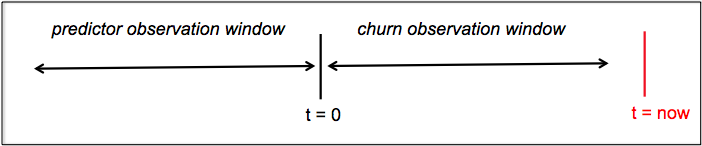

In [2]:
Image(path_images + "churn_sampling_scheme.png")

The point `t = now` is the present time. However, we are interested in the past time `t=0`. The dataset should contain a sample of customer records reflecting the period before `t=0`. Here `predictor` indicates the antecedent of the association rule for the prediction. The period before `t=0` should allow customer relations to observe any feature relevant to association rules. Following `t=0`, the customer can terminate or suspend subscription of service. We can check the period between `t=0` and `t=now` for any customer churn. Note that we could repeat the study with a different sample of customer records corresponding to a different past time `t=0`.

In [3]:
churn_data = pd.read_csv(path_dataset)
churn_data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
churn_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


We have a dataset consisting of 7043 records and 21 features including `Churn`. We will use the model to determine combinations of features indicative of customer churn. However, we need to target features relevant to customer churn in the sample. If we were not able to confer with experienced employees in customer relations about risk factors for customer churn in telecommunications, then we would need to explore many samples to determine possible features relevant to the business tasks. 

In [5]:
churn_data.describe(include = "all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,8728-SKJLR,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


Note that `customerID` is the unique identifier of customers in the sample. Since we cannot use `customerID` for a feature in the model to predict customer churn, we can drop the unique identifier from the table.

In [6]:
customer_id = churn_data["customerID"]
churn_data = churn_data.drop(columns = ["customerID"])

We find that `SeniorCitizen` is a categorical variable. However, the table encodes `SeniorCitizen` with 0 or 1. 

In [7]:
churn_data["SeniorCitizen"] = churn_data["SeniorCitizen"].replace({0:"No", 1:"Yes"})

The missing values for summary statistics of the `TotalCharges` column indicate that the entries lack a numerical data type.

In [8]:
churn_data["TotalCharges"] = pd.to_numeric(churn_data["TotalCharges"], errors="coerce")

We have 11 records with missing values in the `TotalCharges` column. 

In [9]:
churn_data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
                    ..
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
Length: 20, dtype: int64

Use the `pandas` function `dropna` to remove these records.

In [10]:
axis = ...
axis = 1
# YOUR CODE HERE
#raise NotImplementedError()

churn_data = churn_data.dropna(axis = axis)

In [11]:
churn_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
                   ..
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
Length: 19, dtype: int64

In [12]:
# TEST 

assert type(axis) == int


Remember that we have categorical data and numerical data. We can uses the missing values in the summary statistics to distinguish between categorical data and numerical data. In particular, we will use the absence of a mean to indicate categorical data.

In [13]:
mean_values = churn_data.describe(include="all").loc["mean",:]

We learn that we have 16 features of categorical data type besides `Churn`.

In [14]:
categorical_attributes = churn_data.columns[mean_values.isna()]
categorical_attributes = categorical_attributes[categorical_attributes != "Churn" ]
categorical_attributes

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

We learn that we have 3 features of numerical data type.

In [15]:
numerical_attributes = churn_data.columns[~mean_values.isna()]
numerical_attributes

Index(['tenure', 'MonthlyCharges'], dtype='object')

We will need to convert the features of numerical data type to categorical data for the model. 

In [16]:
churn_data_processed = churn_data.copy()

For each column, we will group the entries into 

- 0th - 20th percentile 
- 20th - 40th percentile
- 40th - 60th percentile
- 60th - 80th percentile
- 80th - 1000th percentile

We can use the `pandas` function `qcut` to label the data corresponding the ranges. Determine the value for the argument 

In [17]:
q = ...
q= 5

# YOUR CODE HERE
#raise NotImplementedError()

for attribute in numerical_attributes:
    churn_data_processed[attribute] = pd.qcut(churn_data_processed[attribute], q = q)

In [18]:
# TEST 

assert len(churn_data_processed["tenure"].unique()) == 5


We will need to fit the model to the data. We can simplify the data with a numerical encoding for the categories. We will use the `LabelEncoder` transformation in the `sklearn` package. Note that the `sklearn` package has many helpful transformations to process data for modelling. 

In [19]:
encoders = dict()

for attribute in churn_data.columns:
    encoder = sklearn.preprocessing.LabelEncoder()
    
    churn_data_processed[attribute] = encoder.fit_transform(churn_data_processed[attribute].values)
    
    encoders[attribute] = encoder
    
    churn_data_processed[attribute] = churn_data_processed[attribute].map(lambda x : "({},{})".format(attribute, x))

Note that we store the information about the encoding in the dictionary `encoders`.

In [20]:
encoders["gender"].inverse_transform([0,1])

array(['Female', 'Male'], dtype=object)

Which of the following options corresponds to the encoding of the `DeviceProtection` column.

1. `[0,1,2]` corresponds to `['No', 'No internet service', 'Yes']`
1. `[0,1,2]` corresponds to `['Yes', 'No internet service', 'No']`
1. `[0,1,2]` corresponds to `['No internet service', 'No', 'Yes']`

In [21]:
encoders["DeviceProtection"].inverse_transform([0,1,2])

array(['No', 'No internet service', 'Yes'], dtype=object)

In [22]:
type(encoders["DeviceProtection"])

sklearn.preprocessing._label.LabelEncoder

In [23]:
q_encoding = ...
result = {
    1 : ['No', 'No internet service', 'Yes'],
    2 : ['Yes', 'No internet service', 'No'],
    3 : ['No internet service', 'No', 'Yes']
}
output = encoders["DeviceProtection"].inverse_transform([0,1,2])
answer = (list)(output)
for key, value in result.items():
    if value==answer:
        q_encoding = key
q_encoding        

# YOUR CODE HERE
#raise NotImplementedError()

1

In [24]:
# TEST 

assert q_encoding in [1,2,3]


Since we will use Spark MLlib to implement the model, we need to convert the rows to lists.

In [25]:
churn_data_processed = churn_data_processed.apply(lambda x : list(x), axis = 1)

churn_data_processed = churn_data_processed.to_frame()
churn_data_processed.columns = ["items"]

churn_data_processed["customerID"] = customer_id
churn_data_processed.head(3)

,items,customerID
0,"[(gender,0), (SeniorCitizen,0), (Partner,1), (...",7590-VHVEG
1,"[(gender,1), (SeniorCitizen,0), (Partner,0), (...",5575-GNVDE
2,"[(gender,1), (SeniorCitizen,0), (Partner,0), (...",3668-QPYBK


### Exploratory Data Analysis

Before we understand the data in a quantitative way, we should try to understand the data in a qualitative way. If we find inconsistencies, inaccuracies or outliers in the records, then we can repeat the data processing. If we identify relationships in customer behavior, particularly the features linked to churn, then we could focus on these relationships in the model. Moreover we could report possible risk factors for customer churn to customer relations. Any insights into customer dissatisfaction would help to mitigate customer churn.  

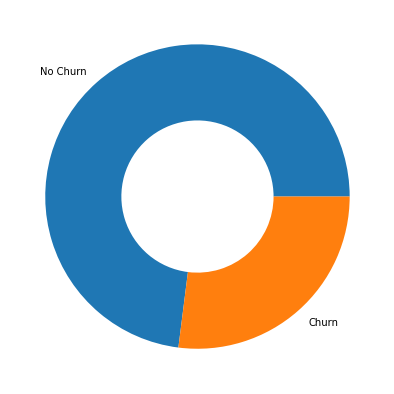

In [26]:
plt.pie([0.73,0.27], wedgeprops=dict(width=0.5), labels=["No Churn", "Churn"]);

Aournd 25\% of customers in the sample suspended or terminated subscription to services between `t=0` and `t=now`.

Use the `pandas` function `value_counts` to determine the number of customers records with `Yes` and `No` in the `Churn` column of `churn_dataset`.

In [27]:
number_yes = ...
number_no = ...
result = churn_data['Churn'].value_counts()
number_yes = result[1]
number_no = result[0]

# YOUR CODE HERE
#raise NotImplementedError()

In [28]:
# TEST 

assert 1000 <= number_yes < 2000
assert 5000 <= number_no < 6000


Remember that we have 16 features of categorical data type. For each feature we can generate a bar-chart. The bar-chart shows the distribution of `Yes` and `No` in the `Churn` columns for the different values of the features.

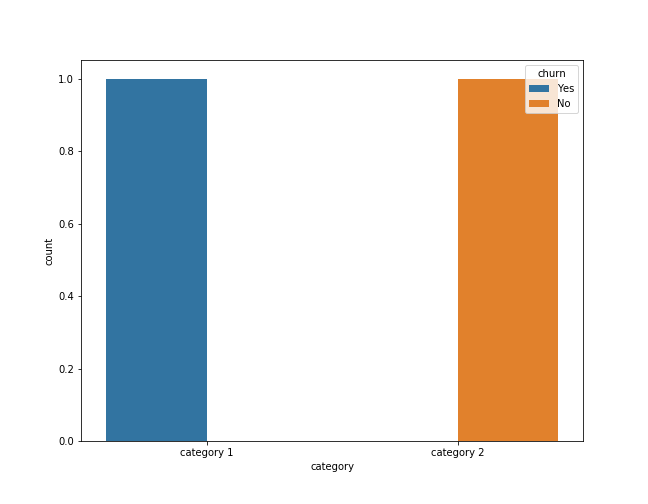

In [29]:
Image(path_images + "barchart_1.png")

We want to determine features that distinguish between `Yes` and `No` in the `Churn` column. If the bar-chart indicates a division between `Yes` and `No` among the values of the features, then the feature has a close relationship with `Churn`. 

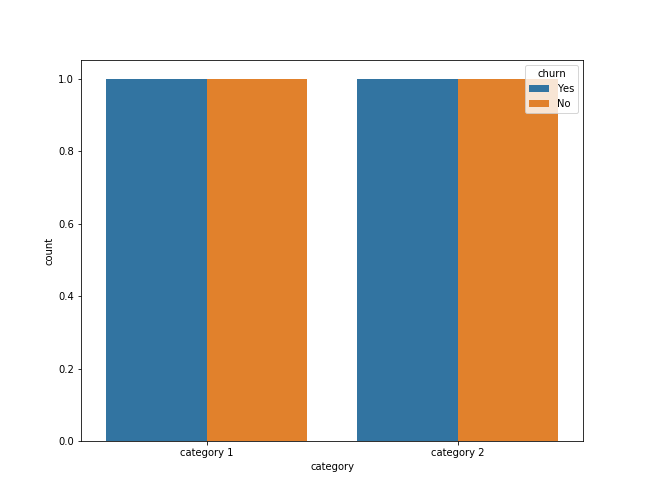

In [30]:
Image(path_images + "barchart_3.png")

If the bar-chart does not indicate a division between `Yes` and `No` among the values of the features, then the feature does not have a close relationship with `Churn`. The values of the feature cannot help us to predict `Churn`.

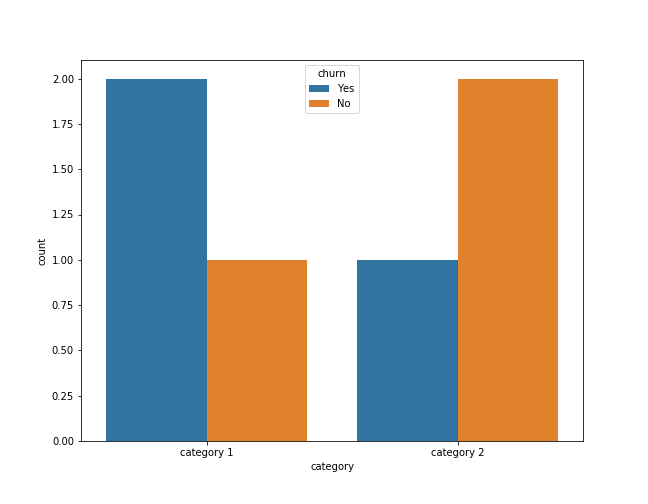

In [31]:
Image(path_images + "barchart_2.png")

Commonly, we find some division in the bar-chart between `Yes` and `No` among the values of the features. Based on the different portions between `Yes` and `No`, we can assess the strenght of the relationship with `Churn`. We might be able predict `Churn`. However, we might not have a reliable prediction.

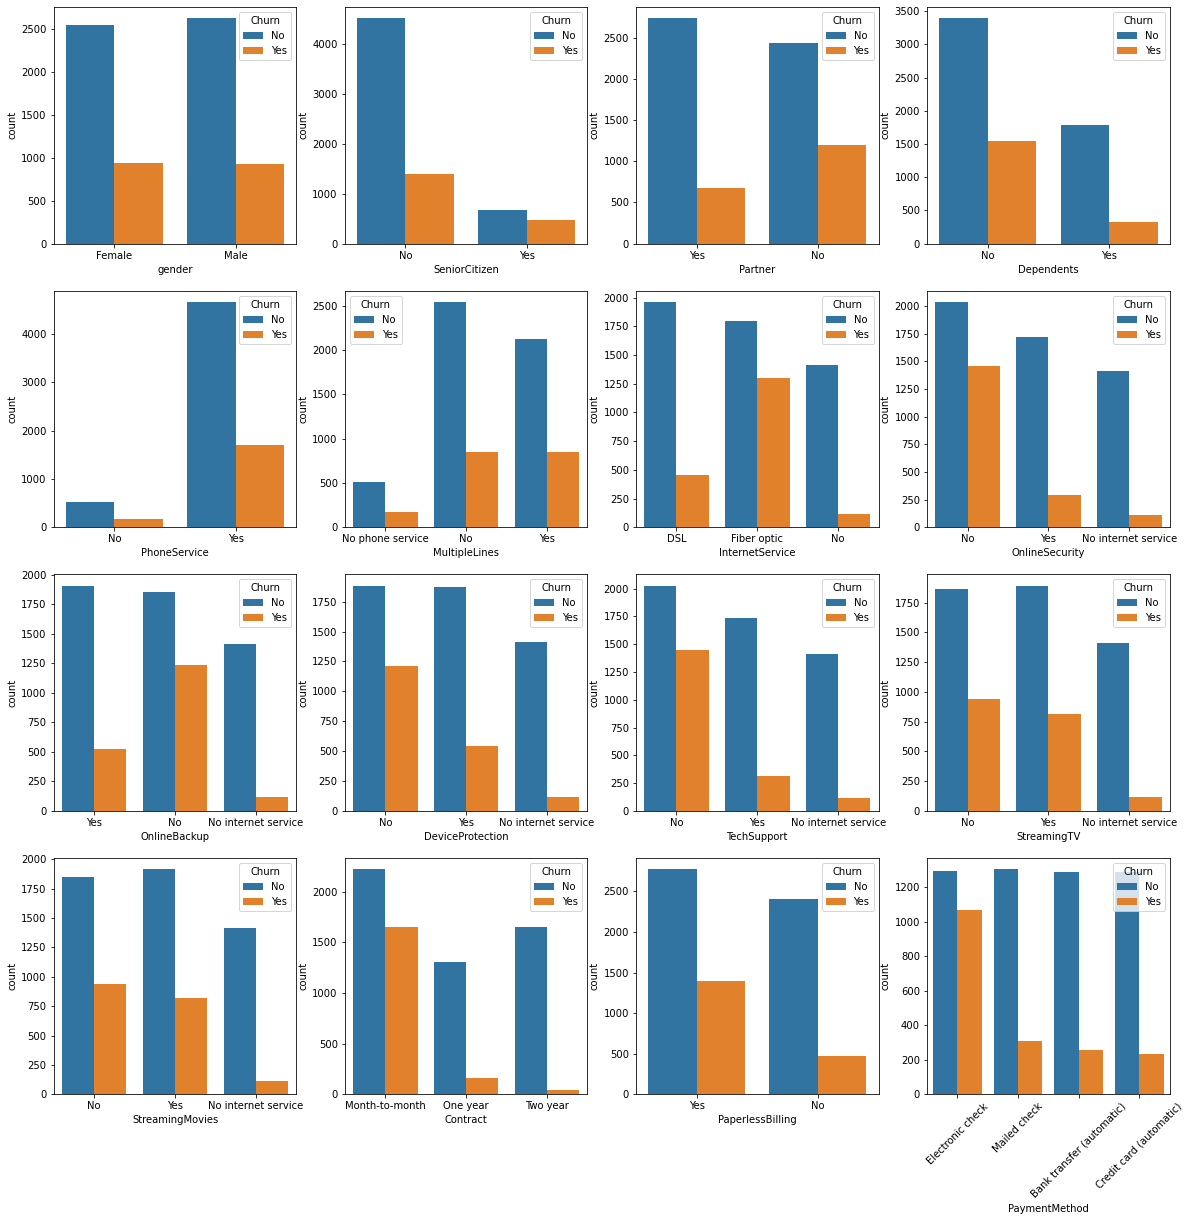

In [32]:
fig, axes = plt.subplots(4,4, figsize = (20,20))

for attribute, ax in zip(categorical_attributes, axes.flatten()):
    sns.countplot(x = attribute, hue="Churn", data = churn_data, ax = ax)

plt.xticks(rotation = 45);

In [33]:
churn_data.corr()

,tenure,MonthlyCharges
tenure,1.0000,0.2479
MonthlyCharges,0.2479,1.0000


In [34]:
churn_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


In [35]:
gender = churn_data['gender']
partner = churn_data['Partner']
churn = churn_data['Churn']

gender_diff = 0
partner_diff = 0



for i in range(0,len(gender)):
    if gender[i]=='Male' and churn[i]=='Yes':
        gender_diff = gender_diff + 1;
    if gender[i]=='Male' and churn[i]=='No':
        gender_diff = gender_diff - 1;
    if gender[i]=='Female' and churn[i]=='Yes':
        gender_diff = gender_diff + 1;
    if gender[i]=='Female' and churn[i]=='No':
        gender_diff = gender_diff - 1;
gender_diff = abs(gender_diff)

for i in range(0,len(partner)):
    if partner[i]=='Yes' and churn[i]=='Yes':
        partner_diff = partner_diff + 1;
    if partner[i]=='No' and churn[i]=='No':
        partner_diff = partner_diff - 1;
    if partner[i]=='Yes' and churn[i]=='Yes':
        partner_diff = partner_diff + 1;
    if partner[i]=='No' and churn[i]=='No':
        partner_diff = partner_diff - 1;
partner_diff = abs(partner_diff)

        


__True or False__ : Based on the bar-chart, the feature `gender` would be a better predictor of `Churn` than the feature  `Partner`.

In [36]:
q_barchart_1 = ...

#False
q_barchart_1 = gender_diff > partner_diff
q_barchart_1
# YOUR CODE HERE
#raise NotImplementedError()

False

In [37]:
# TEST 

assert q_barchart_1 in [True, False]


__True or False__ : Based on the scatter-plots, the value `Electronic check` for the feature `PaymentMethod` would be a risk factor for `Yes` in `Churn`.

In [38]:
q_barchart_2 = ...
q_barchart_2 = True

# YOUR CODE HERE
#raise NotImplementedError()

In [39]:
# TEST 

assert q_barchart_2 in [True, False]


In [40]:
churn_data


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


Remember that we have 3 features of numerical data type. We can use histograms to understand the distribution of values for each feature. We can use scatter-plots to understand the relationship between pairs of features. We will use the `seaborn` function `PairGrid` to combine the histograms and scatter-plots.

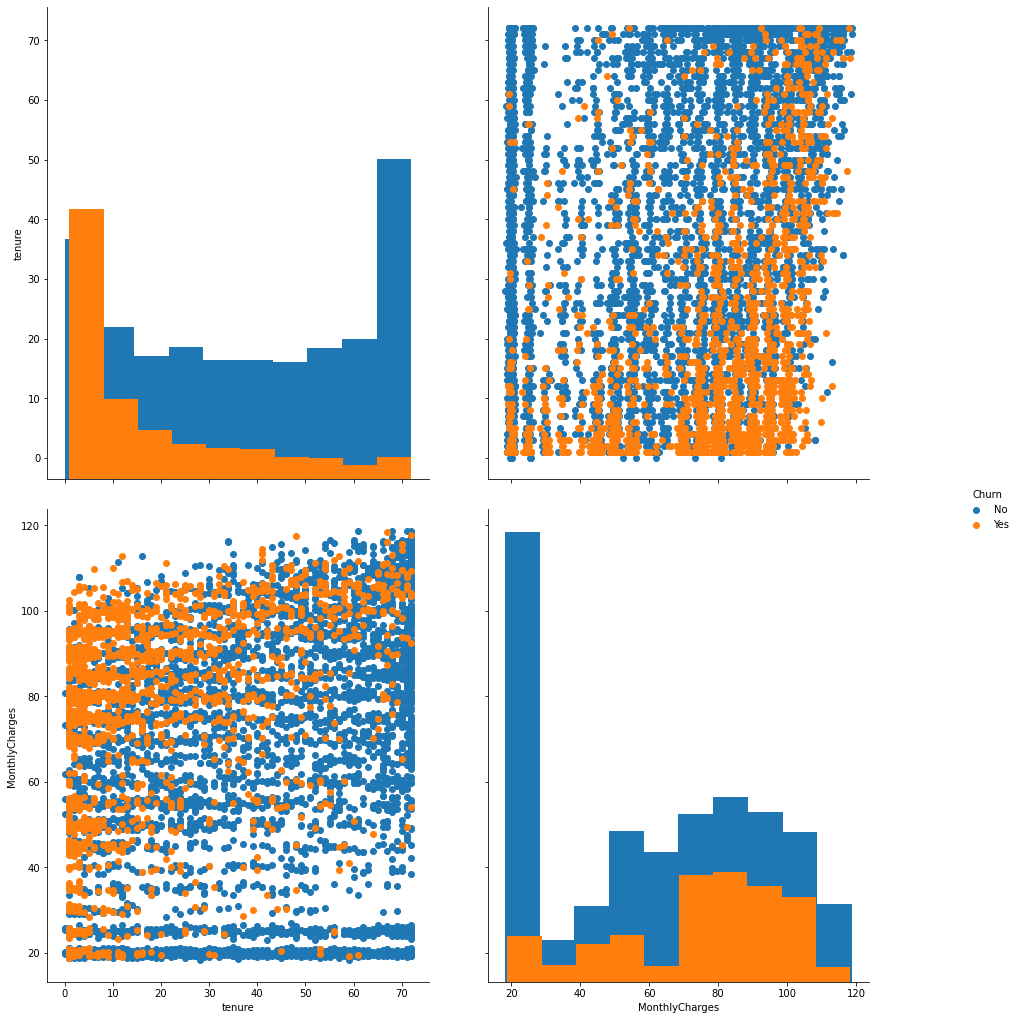

In [41]:
chart = sns.PairGrid(data = churn_data, hue = "Churn")
chart = chart.map_diag(plt.hist)
chart = chart.map_offdiag(plt.scatter)
chart.add_legend()
chart.fig.set_size_inches(15,15);

If a feature will help us to predict `Churn`, then we need to find a difference in the histogram between `Yes` and `No`.

__True or False__ : Based on the histograms, the feature `tenure` would be a better predictor of `Churn` than the feature  `TotalCharges`.

In [42]:
q_histograms = ...
q_histograms = False
# YOUR CODE HERE
#raise NotImplementedError()

In [43]:
# TEST 

assert q_histograms in [True, False]


We have 3 features `tenure`, `MonthlyCharges`, and `TotalCharges`. Some of the scatter-plots show a relationship between features through a pattern in the points. However, other scatter-plots have no discernible pattern.

__True or False__ : Based on the scatter-plots, the features `tenure` and `TotalCharges` have a closer relationships than the features `tenure` and `MonthlyCharges`.

In [44]:
q_scatterplots = ...
q_scatterplots = False
# YOUR CODE HERE
#raise NotImplementedError()

In [45]:
# TEST 

assert q_scatterplots in [True, False]


### Modeling

While we have different approaches to data mining, we might have restrictions in a business setting. Operational issues like infrastructure limitations or regulatory policies might prevent us from employing some approaches. We need to ensure that the model is 

- usable 
  * we need to have a model with an efficient and scalable implementation 
- interpretable 
  * we must explain the model to stake-holders 
- robust 
  * we have to evaluate the model against different datasets 
  
Remember that we need to determine a model that meet the requirements of the job task analysis. So operational issues are constraints on the analysis.  

In [46]:
churn_data_processed_random_order = churn_data_processed.sample(frac=1, random_state=42)
churn_data_processed_random_order.head(3)

,items,customerID
185,"[(gender,0), (SeniorCitizen,0), (Partner,1), (...",1024-GUALD
2715,"[(gender,1), (SeniorCitizen,0), (Partner,0), (...",0484-JPBRU
3825,"[(gender,0), (SeniorCitizen,0), (Partner,1), (...",3620-EHIMZ


We need to break the dataset into two datasets called the training set and the testing set. We will determine the association rules for prediction with the training set. Here we fit the model to the data in the training set. We will evaluate the predictions on the testing set. The testing set helps us to assess the accuracy of the predictions outside sample that determined the rules for prediction.

We use the `pandas` function `sample` to shuffle the rows of `churn_data_processed`. Here we use the argument `random_state` to allow for reproducible permutation of the rows. While we shuffle the rows at random, we obtain the same permuation for  `random_state = 42`.

In [47]:
size_training_set = 0.8

number_rows = int(size_training_set * len(churn_data_processed_random_order))

train = churn_data_processed_random_order.iloc[:number_rows,:]
test = churn_data_processed_random_order.iloc[number_rows:,:]

Here we use 80\% of the data for the training set and 20\% of the data for the testing set. We need to split at random to avoid differences between training set and testing set. For example, if the rows of `churn_dataset_processed` were sorted by the values in the `Churn` column, then the testing set could just consist of customers who discontinued subscription of services. 

In [48]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()

We will use the MLlib component of Spark to fit the model to the data.

In [49]:
train_spark = spark.createDataFrame(train)

Remeber that Spark implements the FPGrowth algorithm for determining frequent patterns and association rules. We need to specify the minimum relative support and the minimum confidence.

In [50]:
minimum_relative_support = 0.1
minimum_confidence = 0.95

Now we can fit the model to the data.

In [51]:
fpGrowth = pyspark.ml.fpm.FPGrowth(itemsCol="items", minSupport=minimum_relative_support, minConfidence=minimum_confidence)

model = fpGrowth.fit(train_spark)

We can access the frequent patterns from the `freqItemsets` attribute of the model.

In [52]:
model.freqItemsets.show(3)

+--------------------+----+
|               items|freq|
+--------------------+----+
|  [(OnlineBackup,2)]|1941|
|[(OnlineBackup,2)...| 627|
|[(OnlineBackup,2)...| 957|
+--------------------+----+
only showing top 3 rows



We can access the association patterns from the `associatioRules` attribute of the model.

In [53]:
model.associationRules.show(3)

+--------------------+--------------------+------------------+------------------+
|          antecedent|          consequent|        confidence|              lift|
+--------------------+--------------------+------------------+------------------+
|[(MonthlyCharges,...| [(SeniorCitizen,0)]|0.9825119236883942|1.1767585412543395|
|[(MonthlyCharges,...|  [(PhoneService,1)]|               1.0|1.1090551181102362|
|[(MonthlyCharges,...|[(StreamingMovies...|               1.0| 4.694999999999999|
+--------------------+--------------------+------------------+------------------+
only showing top 3 rows



Note that we have metrics `confidence` and `lift` in `associationRules` and the metric `freq` meaning support in `freqItemsets`. So we can join the tables. 

Indicate the appropriate left table and right table for the join.

In [54]:
type(model.freqItemsets)

pyspark.sql.dataframe.DataFrame

In [55]:
right = ...
left = ...

right = model.associationRules
left = model.freqItemsets  

# YOUR CODE HERE
#raise NotImplementedError()

joined = right.join(left, left.items == right.antecedent)

#joined = right.join(left)

**True or False** The columns of `right` contain `antecedent`, `consequent`, `confidence`, `lift`.

In [56]:
r = right.columns
r

['antecedent', 'consequent', 'confidence', 'lift']

In [57]:
q_modelling_1 = ...
r = right.columns
q_modelling_1 = ["antecedent", "consequent", "confidence", "lift"] == r
q_modelling_1
# YOUR CODE HERE
#raise NotImplementedError()

True

In [58]:
# TEST 

assert q_modelling_1 in [True, False]


Now we have to filter the table. We want the conseqient to be `[(Churn,0)]` or `[(Churn,1)]`.

In [59]:
joined_filtered = joined.where(F.size(F.col("consequent")) == 1).where(F.col("consequent")[0].like("%Churn%").alias("consequent")) 
joined_filtered.show(3)

+--------------------+-----------+------------------+------------------+--------------------+----+
|          antecedent| consequent|        confidence|              lift|               items|freq|
+--------------------+-----------+------------------+------------------+--------------------+----+
|[(Contract,2), (g...|[(Churn,0)]|0.9651162790697675|1.3191327307809486|[(Contract,2), (g...| 602|
|[(Contract,2), (D...|[(Churn,0)]|0.9560439560439561|1.3067325687413025|[(Contract,2), (D...| 637|
|[(Contract,2), (T...|[(Churn,0)]|0.9668769716088328|1.3215392668714614|[(Contract,2), (T...| 634|
+--------------------+-----------+------------------+------------------+--------------------+----+
only showing top 3 rows



We took the minimum relative support to be 10\% and the minimum confidence to be 0.95. If we want to allow for more association rules, then we could fit another model with  

- minimum relative support to be 5\%   
- minimum confidence to be 0.75

We have the association rules of the model with consequent `[(Churn,1)]` or `[(Churn,0)]` in `churn_association_rules.csv`. 

In [60]:
association_rules = pd.read_csv(path_association_rules)
association_rules.head()

,antecedent,confidence,consequent,freq,lift
0,"{'(SeniorCitizen,0)', '(PhoneService,1)', '(Co...",0.88,"['(Churn,0)']",527,1.19
1,"{'(Dependents,0)', '(Contract,2)', '(PhoneServ...",0.99,"['(Churn,0)']",336,1.34
2,"{'(StreamingMovies,2)', '(StreamingTV,2)', '(P...",0.94,"['(Churn,0)']",343,1.28
3,"{'(Partner,1)', '(DeviceProtection,1)', '(Mult...",0.95,"['(Churn,0)']",297,1.29
4,"{'(OnlineBackup,1)', '(MultipleLines,0)', '(De...",0.92,"['(Churn,0)']",672,1.25


We have an association rule with antecedent 

`['(Contract,2)', '(InternetService,0)','(OnlineBackup,2)','(SeniorCitizen,0)']`

The association rule has 

- absolute support 332
- confidence 1
- lift 1.35

We can use `encoders` to transform the numbers `2,0,2,0` back to strings. Which option corresponds to antecedent under the encoding

1. `['(Contract,One Year)', '(InternetService,Fiber Optic)','(OnlineBackup,Yes)','(SeniorCitizen,No)']`
1. `['(Contract,Two Year)', '(InternetService,DSL)','(OnlineBackup,Yes)','(SeniorCitizen,No)']`
1. `['(Contract,Monthly)', '(InternetService,DSL)','(OnlineBackup,No)','(SeniorCitizen,Yes)']`

In [61]:
q_antecedents = ...
association = 2
q_antecedents = association
# YOUR CODE HERE
#raise NotImplementedError()

In [62]:
# TEST 

assert q_antecedents in [1,2,3]


### Evaluation

Remember that 75\% of customers have `No` for `Churn` and 25\% of customers have `Yes` for `Churn`. Since the number of occurrences of `Yes` is three times the number of occurrences of `No`, we lack frequent patterns containing the consequent `[(Churn,1)]`.

In [63]:
association_rules["consequent"].unique()

array(["['(Churn,0)']"], dtype=object)

We find that the 60363 association rules in `association_rules` have consequent `[(Churn,0)]`. Based on these association rules, we would just predict `[(Churn,0)]`. However, the model needs to predict `[(Churn,1)]` to match customer records in the testing set. So we can apply the following steps to make predictions on the testing set

1. For a customer record, we check `association_rules` for matching antecents. 
1. If the customer record contains the itemset of an antecedent, then we predict `[(Churn,0)]`
1. Otherwise we lack a matching antecedent. We predict `[(Churn,1)]`

We can make prediction for the 1407 customer records in the testing set.

In [64]:
test_merge = pd.merge(left = test, right = churn_data.loc[test.index,"Churn"], right_index=True, left_index=True)
test_merge["items"] = test_merge["items"].map(lambda x : set(x))
test_merge.head(3)

,items,customerID,Churn
6899,"{(PaymentMethod,0), (SeniorCitizen,0), (Stream...",3926-CUQZX,Yes
1555,"{(tenure,3), (OnlineSecurity,2), (gender,0), (...",9651-GTSAQ,Yes
6800,"{(OnlineSecurity,2), (gender,0), (StreamingTV,...",1113-IUJYX,Yes


Suppose we have the records for customer `7338-ERIVA`.

> {'(Churn,0)',
   '(Contract,1)',
   '(Dependents,1)',
   '(DeviceProtection,0)',
   '(InternetService,0)',
   '(MonthlyCharges,1)',
   '(MultipleLines,1)',
   '(OnlineBackup,0)',
   '(OnlineSecurity,2)',
   '(PaperlessBilling,0)',
   '(Partner,0)',
   '(PaymentMethod,0)',
   '(PhoneService,0)',
   '(SeniorCitizen,0)',
   '(StreamingMovies,0)',
   '(StreamingTV,2)',
   '(TechSupport,2)',
   '(TotalCharges,2)',
   '(gender,1)',
   '(tenure,2)'}
   
Since the value in `Churn` is 0 corresponding to `No`, we learn that the customer continued subscription to services. We can scan the antecedents in `association_rules`. We find 266 matching antecedents. For example, we have the itemset 

> {'(InternetService,0)',
  '(MonthlyCharges,1)',
  '(PaperlessBilling,0)',
  '(SeniorCitizen,0)',
  '(StreamingMovies,0)'}

Which of the following itemsets would not match the records for customer `7338-ERIVA`.

1.  {'(InternetService,0)',
  '(OnlineSecurity,2)',
  '(SeniorCitizen,0)',
  '(StreamingTV,2)'}
1. {'(Partner,1)', '(TechSupport,2)'}
1. {'(MonthlyCharges,1)', '(PhoneService,0)', '(SeniorCitizen,0)'}
1. { '(TechSupport,1)',
   '(gender,1)',
   '(PaperlessBilling,0)'}

In [65]:
q_itemsets = ...

test_list = test_merge['customerID'].tolist()
cnt = 0
for i in range(0,len(test_list)):
    if test_list[i] == '7338-ERIVA':
        cnt = i
        break
test_list_2 = test_merge['items'].tolist()
answer = (list)(test_list_2[cnt])
print(answer)
option1 = ['(InternetService,0)', '(OnlineSecurity,2)', '(SeniorCitizen,0)', '(StreamingTV,2)']
option2 = ['(Partner,1)', '(TechSupport,2)']
option3 = ['(MonthlyCharges,1)', '(PhoneService,0)', '(SeniorCitizen,0)']
option4 = ['(TechSupport,1)', '(gender,1)', '(PaperlessBilling,0)']



ans = []
flag = True
cnt = 0
for i in option1:
    for j in answer:
        if i==j:
            cnt = cnt + 1
if cnt != 0:
    ans.append(1)
cnt = 0
for i in option2:
    for j in answer:
        if i==j:
            cnt = cnt + 1
if cnt != 0:
    ans.append(2)
cnt = 0
for i in option3:
    for j in answer:
        if i==j:
            cnt = cnt + 1
if cnt != 0:
    ans.append(3)
cnt = 0    
for i in option4:
    for j in answer:
        if i==j:
            cnt = cnt + 1
if cnt != 0:
    ans.append(4)
 
ans


q_itemsets = ans

# YOUR CODE HERE
#raise NotImplementedError()

['(PaymentMethod,0)', '(SeniorCitizen,0)', '(StreamingTV,0)', '(MultipleLines,0)', '(Contract,0)', '(TechSupport,0)', '(OnlineSecurity,0)', '(tenure,0)', '(PaperlessBilling,1)', '(gender,1)', '(Churn,1)', '(DeviceProtection,0)', '(InternetService,0)', '(StreamingMovies,0)', '(PhoneService,1)', '(MonthlyCharges,1)', '(Dependents,0)', '(Partner,0)', '(OnlineBackup,0)']


In [66]:
# TEST 

assert type(q_itemsets) == list
assert set(q_itemsets).issubset({1,2,3,4})


So we would correctly predict `[(Churn,0)]` for customer `7338-ERIVA`. If we did not find a matching antecedent, then we would have predicted `[(Churn,1)]`.

We can assess the prediction in different ways. Since we want to predict two possible situations, we can use the number of

- True Positive 
 * Correctly predict `Yes` for `Churn`
- True Negative 
 * Correctly predict `No` for `Churn`
- False Positive 
 * Incorrectly predict `Yes` for `Churn`
- False Negative 
 * Incorrectly predict `No` for `Churn`

We tend to arrange these numbers into a diagram called a confusion matrix. We can use a `heatmap` in the `seaborn` package to add labels and colors.

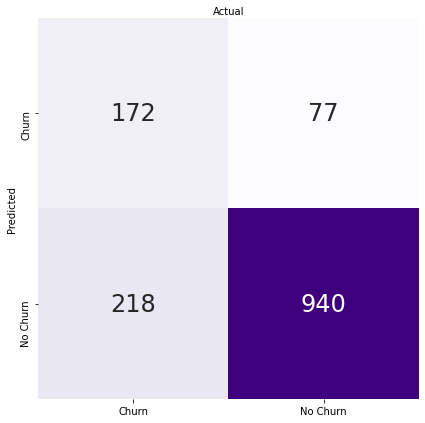

In [67]:
TP = 172
TN = 940
FP = 77
FN = 218

confusion_matrix = np.array([
    [TP, FP],
    [FN, TN],
])

sns.heatmap(confusion_matrix, annot=True, fmt='d',
            cmap="Purples", annot_kws={'fontsize': 24}, square=True,
            xticklabels=["Churn", "No Churn"], yticklabels=["Churn", "No Churn"], cbar=False)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Actual')
plt.ylabel('Predicted');

We can use the number of true postive, false positive, true negative and false negative to compute

- error rate
 * ratio of number of incorrect predictions to number of predictions
- recall
 * ratio of number of true positives to sum of number of true positives and false negatives.
 
The error rate measures the number of incorrect predictions. The recall measures the number of correct prediction among customers who discontinue subscription of service.

In [68]:
err = (FP + FN) / (TP + TN + FP + FN)
err

0.20966595593461265

In [69]:
recall = TP / (TP + FN)
recall

0.441025641025641

Suppose we had the following numbers

- True Positive
  * 244
- False Positive
  * 123
- False Negative
  * 146
- True Negative
  * 894 
  
Compute the error rate and recall.

In [70]:
TP = 244
FP = 123
FN = 146
TN = 894

err = (FP + FN) / (TP + TN + FP + FN)
print(err)
recall = TP / (TP + FN)
print(recall)

0.1911869225302061
0.6256410256410256


In [71]:
q_err = ...
q_recall = ...
TP = 244
FP = 123
FN = 146
TN = 894

err = (FP + FN) / (TP + TN + FP + FN)
print(err)
recall = TP / (TP + FN)
print(recall)

q_err = err
q_recall = recall

# YOUR CODE HERE
#raise NotImplementedError()

0.1911869225302061
0.6256410256410256


In [72]:
# TEST 

assert 0.1 < q_err < 0.2


In [73]:
# TEST 

assert 0.5 < q_recall < 0.7


Based on support, confidence, and lift, we can filter the table `association_rules`. With fewer association rules, we would have fewer matching antecedents for the customer records in the testing set. So we would have more predictions of `[(Churn,1)]`. If we have more predictions of `[(Churn,1)]`, then we could have an increase in recall.

In [74]:
evaluations = pd.read_csv(path_evaluation)
evaluations

,confidence,freq,lift,tp,fp,fn,tn,err,recall
0,0.75,287.0,1.02,11,3,379,1014,0.271500,0.028205
1,0.75,287.0,1.21,172,77,218,940,0.209666,0.441026
2,0.75,287.0,1.24,244,123,146,894,0.191187,0.625641
3,0.75,287.0,1.29,346,373,44,644,0.296375,0.887179
4,0.75,347.0,1.02,11,3,379,1014,0.271500,0.028205
...,...,...,...,...,...,...,...,...,...
59,0.95,396.0,1.29,364,512,26,505,0.382374,0.933333
60,0.95,495.0,1.02,370,571,20,446,0.420043,0.948718
61,0.95,495.0,1.21,370,571,20,446,0.420043,0.948718
62,0.95,495.0,1.24,370,571,20,446,0.420043,0.948718


Here we have 64 combinations of ranges for support, confidence and lift. For each combination, we compute the true postive, false positive, true negative, false negative, error rate and recall for the predictions. For example, if we filter `association_rules`  

- confidence > 0.95	
- support > 396
- lift > 1.29

then we have

- True Positive
  * 364
- False Positive
  * 512
- False Negative
  * 26
- True Negative
  * 505
- Error Rate
  * 0.382374	
- Recall  
  * 0.933333

Compare the performance for the following combinations of support, confidence and lift. 

In [75]:
evaluations.loc[2,:]

confidence      0.750000
freq          287.000000
lift            1.240000
tp            244.000000
fp            123.000000
fn            146.000000
tn            894.000000
err             0.191187
recall          0.625641
Name: 2, dtype: float64

In [76]:
evaluations.loc[46,:]

confidence      0.910000
freq          495.000000
lift            1.240000
tp            285.000000
fp            213.000000
fn            105.000000
tn            804.000000
err             0.226013
recall          0.730769
Name: 46, dtype: float64

While both combinations have lift `1.24`, we have 

- confidence 0.75, support 287
- confidence 0.91, support 495

With low confidence and low support, we have many association rules. With many antecedents, we have a greater chance of matching an antecedent to a customer record. So we have a great chance of predicting `No` for `Churn`. With high confidence and high support, we have fewer association rules. With fewer antecedents, we have a lesser chance of matching an antecedent to a customer record. So we have a lesser chance of predicting `No` for `Churn`. 

__True or False__ If we filtered the association rules by 

- confidence > 0.65	
- support > 20
- lift > 1.24

then we expect 

- recall < 0.62

In [77]:
evaluations['confidence'][1]

0.75

In [78]:
flag = False
for i in range(0,len(evaluations['confidence'])):
    if (evaluations['confidence'][i])>0.65 and (evaluations['freq'][i])>20 and (evaluations['lift'][i])>1.24:
        recall = evaluations['recall'][i]
        print(recall)
        if recall < 0.62:
            flag = True
flag

0.8871794871794871
0.9076923076923076
0.9333333333333332
0.964102564102564
0.8871794871794871
0.9076923076923076
0.9333333333333332
0.964102564102564
0.8871794871794871
0.9076923076923076
0.9333333333333332
0.964102564102564
0.8871794871794871
0.9076923076923076
0.9333333333333332
0.964102564102564


False

In [79]:
q_recall = ...
flag = False
for i in range(0,len(evaluations['confidence'])):
    if (evaluations['confidence'][i])>0.65 and (evaluations['freq'][i])>20 and (evaluations['lift'][i])>1.24:
        recall = evaluations['recall'][i]
        if recall < 0.62:
            flag = True
print(flag)
q_recall = flag
# YOUR CODE HERE
#raise NotImplementedError()

False


In [80]:
# TEST 

assert q_recall in [True, False]


Commonly a prediction model depends on choices like ranges for support, confidence and lift. Depending on the job task analysis we have to tune these components of the model to improve performance. If we want to have an accurate model then we need to filter by support, confidence and lift to decrease error rate. However, if the company incurs less cost from incentivizing an old customer to continue subscription of service than soliciting a new customer through marketing, then recall would be more important than error rate. If the model has greater recall, then the model has greater chance of identifying a dissatisfied customer. So we would need to filter by support, confidence and lift to increase recall.

### Deployment

Having selected a model based on support, confidence and lift, we would need to deploy the model.

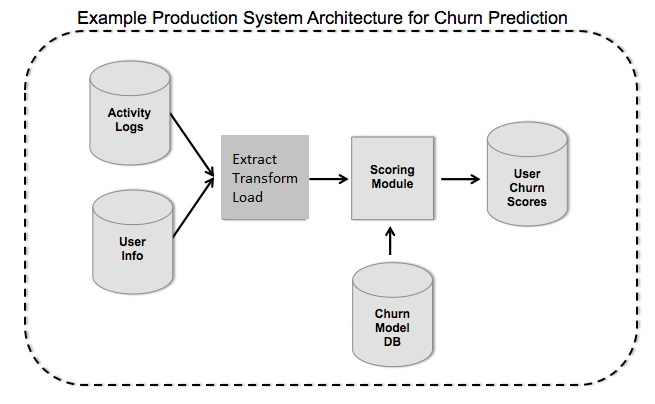

In [81]:
Image(path_images + "churn_architecture_simplified.png")

While we could take different approaches to the deploying the model, the diagram indicates a possible approach.
- Activity Logs & User Info
  * These are the operational database containing customer records</li>
- Extract/Transform/Load
  * We need to process the data for the data warehouse. Here we convert from unstructured data to structured data according to the schema of the data warehouse.
- Churn Model DB 
  * Here we store the association rules need to make the predictions. Remember that we need to match the itemsets in the antecedents. 
- Scoring Module
  * This component inputs a customer records with the relevant features and outputs a prediction based on the association rules
- User Churn Scores 
  * Customer relations would need a front-end system to perform online analytical processing to the predictions of customer churn.


If the telecommunication company wanted an agile approach, then we would need to automate updates to the model. The system would need to fit the data to the model, select the ranges for support, confidence and lift based on benchmarks for error rate or recall, and deploy the model.

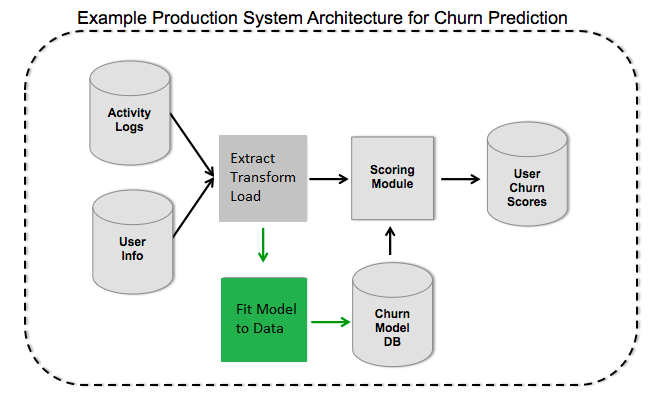

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 45434)
Traceback (most recent call last):
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/site-packages/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/opt/conda/envs/mg-gy-8413/lib/python3.7/site-packages/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/opt/conda/envs/mg-gy-8413

In [82]:
Image(path_images + 'churn_architecture_extended.png') 

Having learned about customer churn for telecommunications companies, we could think about extending the analysis to different sectors like banking, insurance, media or personal fit. While we would need to identify other features, we could many of the same approaches. Hopefully you will find some of the these approaches helpful in your area!